In [1]:
import sys
sys.path.append("../../src/earthtext")

import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from osm import multilabel
from collections import OrderedDict
import pandas as pd
from progressbar import progressbar as pbar
from joblib import Parallel, delayed
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)

get_region_hash = osm.get_region_hash

In [2]:
imgs_folder    = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
osmobjs_folder = "/opt/data/california-worldcover-chips/osm"
master_index   = "/opt/data/california-worldcover-chips.fgb"

In [202]:
from importlib import reload
reload(multilabel)
iosdata = multilabel.ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index).init_index()

In [4]:
OSMMergedKeyValueCodes = multilabel.OSMMergedKeyValueCodes
kvopen   = multilabel.kvopen
kvclosed = multilabel.kvclosed
kvmerged = OSMMergedKeyValueCodes(kvclosed, kvopen)
max_code = np.max(list(kvmerged.keyvals_codes.values()))


In [205]:
reload(multilabel)
chip_id = iosdata.m.index[np.random.randint(len(iosdata.m))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_osm()

In [206]:
c1 = multilabel.ImageOSMChip(iosdata, '1639b12583426').read_osm()
c2 = multilabel.ImageOSMChip(iosdata, '253904d963d6a').read_osm()

In [207]:
ko1,ks1 = c1.get_onehot()
ko2,ks2 = c2.get_onehot()

In [215]:
ko1.T[ko1.T['count']>0].T

,0,1,2,3,4,5,6,7,8,13,...,79,80,82,83,84,88,93,95,96,98
area,160073.78667,160073.78667,801911.039126,313703.535578,290761.493245,38227.968165,129346.837520,9946.119365,19925.085252,0.000000,...,80168.466729,7872.209142,649.865678,10392.166029,49.388928,49.388928,0.000000,0.000000,0.000000,0.000000
length,20966.34466,20966.34466,248811.125914,89664.003904,101019.766066,5970.905269,47376.576044,1503.292171,3276.582459,36772.922916,...,4113.574484,646.728403,108.023817,722.107476,36.656325,36.656325,173.484502,3207.654246,33565.268671,173.484502
count,148.00000,148.00000,4171.000000,1245.000000,1891.000000,52.000000,938.000000,13.000000,32.000000,174.000000,...,25.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,8.000000,166.000000,1.000000


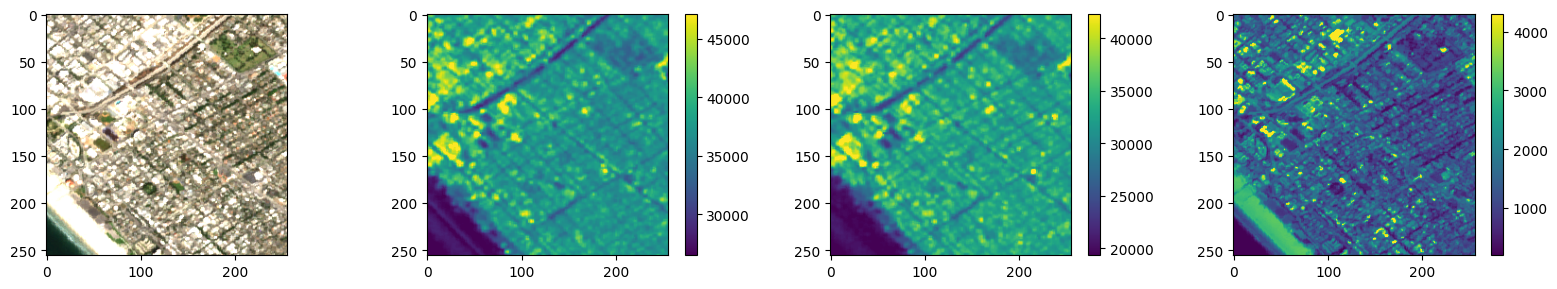

In [216]:
c1.read_img().show()

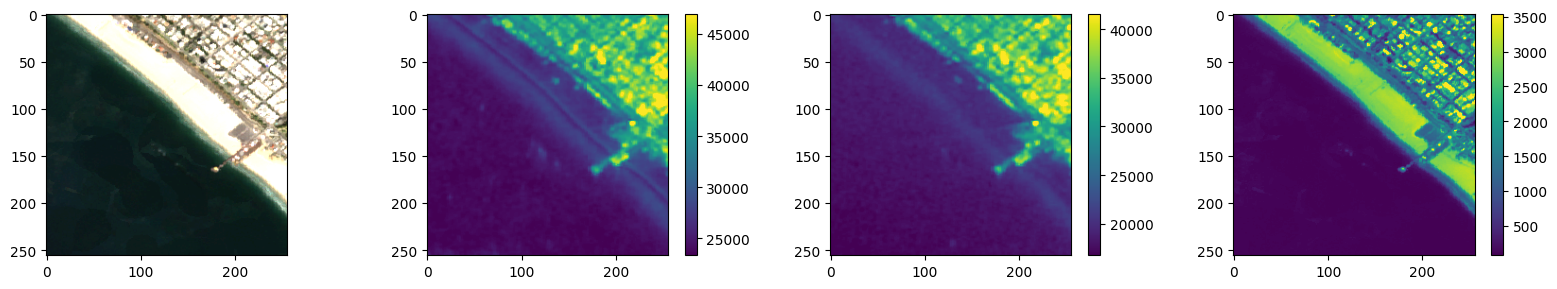

In [217]:
c2.read_img().show()

In [219]:
k = gpd.read_parquet("/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet")
k.head()

,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry,split,esawc_proportions
chip_id,,,,,,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0...",train,"{'10': 0.0118408203125, '100': 0.0, '20': 0.0,..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0...",train,"{'10': 0.0895843505859375, '100': 0.0, '20': 0..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0...",train,"{'10': 0.0130157470703125, '100': 0.0, '20': 0..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0...",train,"{'10': 0.3690948486328125, '100': 0.0, '20': 0..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0...",train,"{'10': 0.1365509033203125, '100': 0.0, '20': 0..."


In [225]:
k.loc[c1.chip_id].onehot_count == ko1.loc['count'].values.astype(int)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## create the multilabels

In [229]:
while True:
    splits = np.linspace(0, len(iosdata.m), 20).astype(int)
    splits[-1]+=1
    splits = [[splits[i], splits[i+1]] for i in range(len(splits)-1)]
    splits = np.random.permutation(splits)
    if splits[0][0] == 17671:
        break
splits

array([[ 17671,  23562],
       [100138, 106029],
       [  5890,  11781],
       [ 35343,  41233],
       [ 82467,  88357],
       [ 41233,  47124],
       [ 76576,  82467],
       [ 70686,  76576],
       [ 29452,  35343],
       [ 94248, 100138],
       [ 47124,  53014],
       [106029, 111921],
       [     0,   5890],
       [ 64795,  70686],
       [ 11781,  17671],
       [ 88357,  94248],
       [ 53014,  58905],
       [ 58905,  64795],
       [ 23562,  29452]])

In [230]:
# 17671 : 23562
reload(osm)
reload(multilabel)

<module 'osm.multilabel' from '/home/ubuntu/earth-text/notebooks/data/../../src/earthtext/osm/multilabel.py'>

In [231]:
from rlxutils import ElapsedTimes
et = ElapsedTimes()

In [232]:
ImageOSMChip = multilabel.ImageOSMChip
r = []

for start,end in splits:
    print (f"\n{start} : {end}", flush=True)
    for chip_id in pbar(iosdata.m.index[start:end]):
        try:
            with et("load"):
                keyval_onehot,keyval_strs = ImageOSMChip(iosdata, chip_id).read_osm().get_onehot()
            with et("extract"):
                onehot_area = keyval_onehot.loc['area'].values.copy()
                onehot_count = keyval_onehot.loc['count'].values.copy()
                onehot_length = keyval_onehot.loc['length'].values.copy()
                keyval_strs = [i for i in keyval_strs]
            with et("append"):
                r.append([chip_id, onehot_count, onehot_area, onehot_length, keyval_strs])
        except:
            continue
            



17671 : 23562


100% (5891 of 5891) |####################| Elapsed Time: 0:13:29 Time:  0:13:290610



100138 : 106029


100% (5891 of 5891) |####################| Elapsed Time: 0:05:34 Time:  0:05:340227



5890 : 11781


100% (5891 of 5891) |####################| Elapsed Time: 0:04:26 Time:  0:04:260222



35343 : 41233


100% (5890 of 5890) |####################| Elapsed Time: 0:02:31 Time:  0:02:310111



82467 : 88357


100% (5890 of 5890) |####################| Elapsed Time: 0:04:12 Time:  0:04:120220



41233 : 47124


100% (5891 of 5891) |####################| Elapsed Time: 0:02:10 Time:  0:02:100:14



76576 : 82467


100% (5891 of 5891) |####################| Elapsed Time: 0:03:36 Time:  0:03:360117



70686 : 76576


100% (5890 of 5890) |####################| Elapsed Time: 0:03:11 Time:  0:03:110115



29452 : 35343


100% (5891 of 5891) |####################| Elapsed Time: 0:03:49 Time:  0:03:490118



94248 : 100138


100% (5890 of 5890) |####################| Elapsed Time: 0:06:52 Time:  0:06:520335



47124 : 53014


100% (5890 of 5890) |####################| Elapsed Time: 0:00:51 Time:  0:00:510003



106029 : 111921


100% (5891 of 5891) |####################| Elapsed Time: 0:03:19 Time:  0:03:191017



0 : 5890


100% (5890 of 5890) |####################| Elapsed Time: 0:01:07 Time:  0:01:070004



64795 : 70686


100% (5891 of 5891) |####################| Elapsed Time: 0:03:08 Time:  0:03:080115



11781 : 17671


100% (5890 of 5890) |####################| Elapsed Time: 0:05:57 Time:  0:05:570222



88357 : 94248


100% (5891 of 5891) |####################| Elapsed Time: 0:03:01 Time:  0:03:010114



53014 : 58905


100% (5891 of 5891) |####################| Elapsed Time: 0:03:00 Time:  0:03:000114



58905 : 64795


100% (5890 of 5890) |####################| Elapsed Time: 0:04:32 Time:  0:04:320221



23562 : 29452


100% (5890 of 5890) |####################| Elapsed Time: 0:03:41 Time:  0:03:410118


In [233]:
et

{'load': 4687.910238265991, 'extract': 8.127020597457886, 'append': 0.10204362869262695}

## create dataframe with multilabels

In [234]:
len(r)

86119

In [235]:
rr = pd.DataFrame(r, columns=['chip_id', 'onehot_count', 'onehot_area', 'onehot_length', 'string_labels'])
rr.set_index('chip_id', inplace=True)
rr['onehot_count'] = [i.astype(np.int32) for i in rr.onehot_count.values]

In [236]:
rr.head()

,onehot_count,onehot_area,onehot_length,string_labels
chip_id,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build..."


In [237]:
rv = pd.DataFrame(np.r_[[list(i>0) for i in rr.onehot_count.values]])

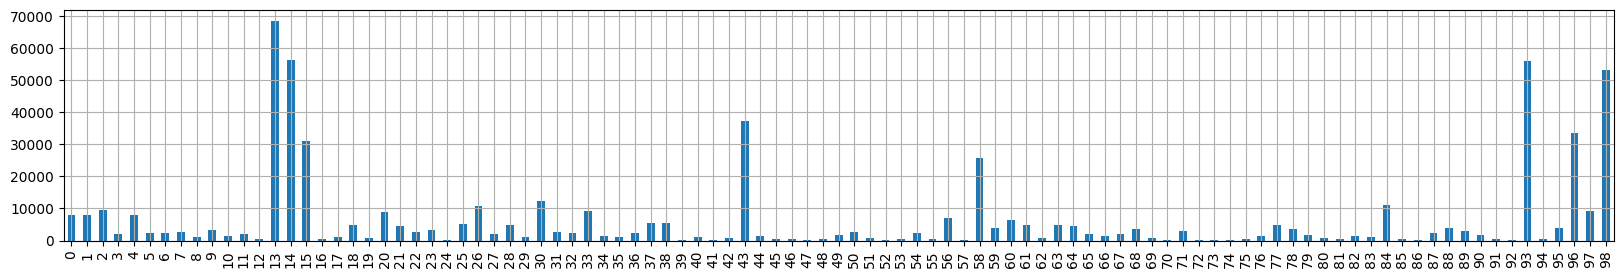

In [238]:
rv.sum(axis=0).plot(kind='bar', figsize=(20,3))
plt.grid();

## join with original metadata dataframe

In [250]:
rohem = gpd.GeoDataFrame(rr.join(iosdata.m), crs=epsg4326)
rohem


,onehot_count,onehot_area,onehot_length,string_labels,col,row,geometry
chip_id,,,,,,,
193c3415fc237,"[24, 24, 1344, 388, 472, 21, 453, 2, 8, 0, 0, ...","[58033.967200952815, 58033.967200952815, 23937...","[4913.205774298301, 4913.205774298301, 74943.4...","[amenity=*, amenity=parking, building=*, build...",78080,96000,"POLYGON ((-118.47200 33.97867, -118.47200 34.0..."
1639b12583426,"[148, 148, 4171, 1245, 1891, 52, 938, 13, 32, ...","[160073.78667008967, 160073.78667008967, 80191...","[20966.344659970102, 20966.344659970102, 24881...","[amenity=*, amenity=parking, building=*, build...",78080,95744,"POLYGON ((-118.47200 34.00000, -118.47200 34.0..."
253904d963d6a,"[65, 65, 200, 104, 76, 0, 18, 2, 0, 0, 0, 0, 0...","[101980.95118259436, 101980.95118259436, 71246...","[10597.989172272657, 10597.989172272657, 16664...","[amenity=*, amenity=parking, building=*, build...",77824,95744,"POLYGON ((-118.49333 34.00000, -118.49333 34.0..."
00530dca88d4a,"[9, 9, 4897, 688, 4026, 0, 172, 10, 1, 0, 0, 0...","[17637.908172952746, 17637.908172952746, 10930...","[1925.4953839123748, 1925.4953839123748, 32065...","[amenity=*, amenity=parking, building=*, build...",77824,95488,"POLYGON ((-118.49333 34.02133, -118.49333 34.0..."
0e554bbdbe661,"[80, 80, 4358, 1262, 2386, 59, 597, 27, 27, 0,...","[131950.60085068244, 131950.60085068244, 98472...","[13536.03447682216, 13536.03447682216, 283601....","[amenity=*, amenity=parking, building=*, build...",78080,95488,"POLYGON ((-118.47200 34.02133, -118.47200 34.0..."
...,...,...,...,...,...,...,...
34c523129af56,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[waterway=*, waterway=river, waterway=stream]",78592,69888,"POLYGON ((-118.42933 36.15467, -118.42933 36.1..."
0756f8e8b2fe2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[waterway=*, waterway=river, waterway=stream]",78592,69632,"POLYGON ((-118.42933 36.17600, -118.42933 36.1..."
0462e105260f1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[landuse=*, landuse=meadow, natural=*, natural...",78848,69632,"POLYGON ((-118.40800 36.17600, -118.40800 36.1..."


In [244]:
rohem.to_parquet("/opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet")

## visualize some chip

In [245]:
chip_id = rohem.index[np.random.randint(len(rohem))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_img().read_osm()

In [246]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
92656044,{'highway': 'motorway_junction'},POINT (-120.89034 37.53338),node,0.000000,0.0,highway: motorway_junction,018d51cef08de
92656063,{'highway': 'traffic_signals'},POINT (-120.88450 37.52199),node,0.000000,0.0,highway: traffic_signals\n<br>\ntraffic_signal...,018d51cef08de
92656786,{'highway': 'motorway_junction'},POINT (-120.89616 37.54053),node,0.000000,0.0,highway: motorway_junction,018d51cef08de
92666221,{'railway': 'level_crossing'},POINT (-120.89506 37.53675),node,0.000000,0.0,railway: level_crossing,018d51cef08de
92666256,{'highway': 'turning_circle'},POINT (-120.88499 37.53635),node,0.000000,0.0,highway: turning_circle,018d51cef08de
...,...,...,...,...,...,...,...
31895,{'highway': 'motorway_link'},"LINESTRING (-120.88694 37.52346, -120.88683 37...",way,110.603016,0.0,bicycle: no\n<br>\ndestination: Denair;Monte V...,018d51cef08de
31896,{'highway': 'motorway_link'},"LINESTRING (-120.88665 37.52184, -120.88657 37...",way,91.227012,0.0,bicycle: no\n<br>\nhighway: motorway_link,018d51cef08de
31897,{'highway': 'tertiary'},"LINESTRING (-120.88879 37.52189, -120.88931 37...",way,46.143885,0.0,highway: tertiary,018d51cef08de
31898,{'highway': 'secondary'},"LINESTRING (-120.88538 37.52185, -120.88446 37...",way,81.714731,0.0,highway: secondary\n<br>\nplacement: right_of:...,018d51cef08de


In [247]:
keyval_onehot,keyval_strs = c.get_onehot()

In [248]:
keyval_strs

['amenity=*',
 'amenity=parking',
 'highway=*',
 'landuse=*',
 'landuse=commercial',
 'landuse=farmland',
 'landuse=farmyard',
 'landuse=industrial',
 'landuse=meadow',
 'landuse=orchard',
 'landuse=residential',
 'landuse=retail',
 'parking=*',
 'parking=surface',
 'highway=motorway',
 'highway=residential']

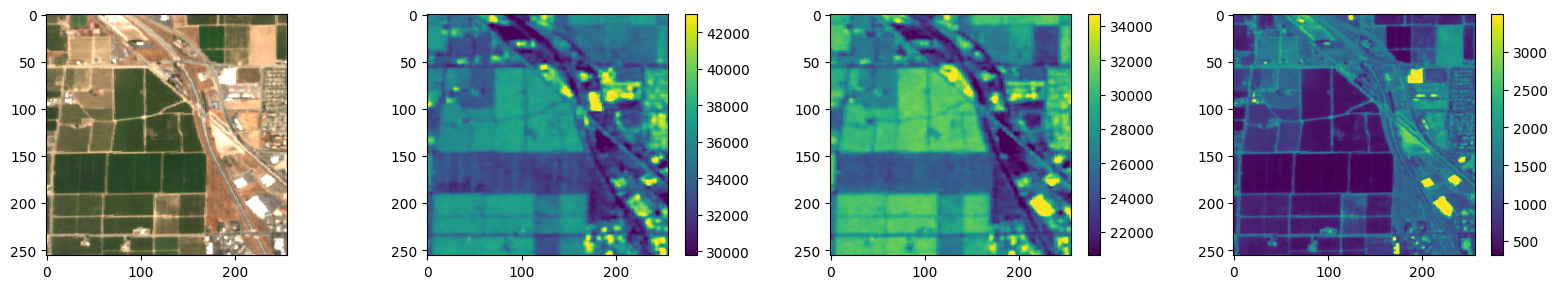

In [249]:
c.show()